# Training a Model with TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate
import nltk

2025-05-31 01:33:02.903015: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 01:33:09.544362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 01:33:09.557719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 01:33:10.674308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 01:33:13.108520: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Testing GPU Support
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2025-05-31 01:34:08.617839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:34:08.791186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:34:08.791235: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Download NLTK punkt for sentence tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# loading the dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", cache_dir="./cache")
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

/mnt/d/github/Text_Summarizer/ts_venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
# Loading the model and tokenizer
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./cache")
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir="./cache")

2025-05-31 01:35:17.932641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:35:17.932762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:35:17.932789: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:35:18.063126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-31 01:35:18.063228: I external/local_xla/xla/stream_executor

In [29]:
# Saving the tokenizer
tokenizer.save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/tokenizer.json')

In [6]:
# Preprocessing function
def preprocess_function(examples):
    # Add prefix for T5 summarization task
    inputs = ["summarize: " + article for article in examples["article"]]
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )
    
    # Tokenize summaries (targets)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"],
            max_length=128,
            truncation=True,
            padding="max_length",
            return_tensors="tf"
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
# Apply preprocessing to datasets
train_dataset = train_data.map(preprocess_function, batched=True)
val_dataset = validation_data.map(preprocess_function, batched=True)
test_dataset = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]/mnt/d/github/Text_Summarizer/ts_venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 11490/11490 [00:05<00:00, 2179.90 examples/s]


In [8]:
# Convert to TensorFlow datasets
def convert_to_tf_dataset(hf_dataset, batch_size=8):
    tf_dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": hf_dataset["input_ids"],
            "attention_mask": hf_dataset["attention_mask"],
            "labels": hf_dataset["labels"]
        }
    ))
    return tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_tf_dataset = convert_to_tf_dataset(train_dataset)
val_tf_dataset = convert_to_tf_dataset(val_dataset)
test_tf_dataset = convert_to_tf_dataset(test_dataset)

In [9]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer)

# Training the model
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=1,
    batch_size=8
)

2025-05-31 01:40:23.196324: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f95503ddee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 01:40:23.197182: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-31 01:40:23.441975: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-31 01:40:23.737888: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1748635823.969758    1531 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35890/35890 [==============================] - 4359s 121ms/step - loss: 1.5982 - val_loss: 1.5121


In [10]:
# saving the model
model.save_pretrained("./t5_small_summarization_model")

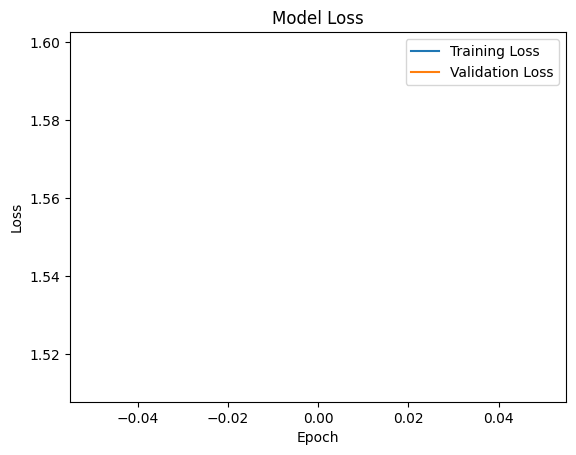

In [ ]:
# Plotting training history
import matplotlib.pyplot as plt

# Explicitly set epoch number as x-axis
epochs = [1]

# Plot with markers to visualize the single point
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Function to generate summaries
def generate_summary(text, model, tokenizer, max_length=128):
    input_text = "summarize: " + text
    inputs = tokenizer(
        input_text,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="tf"
    )
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [26]:
# Evaluation

rogue = evaluate.load("rouge")

# Evaluation function
def evaluate_model(dataset, model, tokenizer, num_samples=100):
    predictions = []
    references = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break
        pred = generate_summary(example["article"], model, tokenizer)
        predictions.append(pred)
        references.append(example["highlights"])
    
    results = rogue.compute(predictions=predictions, references=references)
    return results


In [27]:
eval_results = evaluate_model(test_data.select(range(1)), model, tokenizer)
print("Evaluation Results:", eval_results)

Evaluation Results: {'rouge1': 0.4, 'rouge2': 0.23655913978494622, 'rougeL': 0.35789473684210527, 'rougeLsum': 0.35789473684210527}


In [28]:
# Testing with custom text

# Example custom text (replace with your own text)
custom_text = """
The rapid advancement of artificial intelligence (AI) is transforming industries worldwide. From healthcare to finance, AI technologies are being used to automate tasks, improve decision-making, and enhance user experiences. In healthcare, AI is helping doctors diagnose diseases with greater accuracy through image recognition and predictive analytics. In finance, algorithms are optimizing trading strategies and detecting fraud. However, concerns about job displacement, ethical implications, and data privacy remain significant challenges. Governments and organizations are working to establish regulations to ensure AI is used responsibly.
"""

# Generate summary
generated_summary = generate_summary(custom_text, model, tokenizer)
print("Custom Text (truncated to 500 chars):")
print(custom_text[:500] + "..." if len(custom_text) > 500 else custom_text)
print("\nGenerated Summary:")
print(generated_summary)

Custom Text (truncated to 500 chars):

The rapid advancement of artificial intelligence (AI) is transforming industries worldwide. From healthcare to finance, AI technologies are being used to automate tasks, improve decision-making, and enhance user experiences. In healthcare, AI is helping doctors diagnose diseases with greater accuracy through image recognition and predictive analytics. In finance, algorithms are optimizing trading strategies and detecting fraud. However, concerns about job displacement, ethical implications, and...

Generated Summary:
AI technologies are being used to automate tasks, improve decision-making, and enhance user experiences. In healthcare, AI is helping doctors diagnose diseases with greater accuracy through image recognition and predictive analytics. In finance, algorithms are optimizing trading strategies and detecting fraud. But concerns about job displacement, ethical implications, and data privacy remain significant challenges.
